In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib as mpl
import datetime
import os
from itertools import accumulate
from math import floor
from pandas.tseries.offsets import MonthEnd
import plotting 
from matplotlib.colors import LogNorm, Normalize
from  matplotlib import colormaps as cmaps 
import matplotlib.patches as mpatches
from matplotlib import colors
from os import path
import geopandas as gpd
import json
import re

In [13]:
_HOME_ = path.expanduser("~") + "/PHD"
import modify_dataset

In [14]:
phyto_abundances = pd.read_csv(_HOME_ + "/MSFD/Data/Modulo1/phyto_abund_modified.csv", index_col=0)
phyto_abundances.loc[:, "Date"] = pd.to_datetime(phyto_abundances["Date"])
with open(_HOME_ + "/ISPRA_20152017_Analysis/params.json") as file: 
    params = json.load(file)
best_path = params["best_path"]
best_path_sard = params["best_path_sard"]
ordered_regions = params["ordered_regions"]
seasons = params["seasons"]
sorted_season = params["sorted_season"]
sea_index = params["sea_index"]
ordered_id = params["ordered_id"]
sea_index_array = np.array(list(sea_index.values()))
del params
phyto_abund_simplified = modify_dataset.make_simplified_dataset(phyto_abundances, 0.7)
phyto_abund_simplified = modify_dataset.add_season_column(phyto_abund_simplified, seasons)
phyto_abund_simplified = modify_dataset.add_coast_dist_column(phyto_abund_simplified)
phyto_abund_simplified["Date"] = pd.to_datetime(phyto_abund_simplified["Date"]) + MonthEnd(0)
phyto_abund_simplified["Region"] = pd.Categorical(phyto_abund_simplified["Region"], categories = ordered_regions, ordered = True)
taxonomic_tree = pd.read_excel(_HOME_ + "/ISPRA_20152017_Analysis/Phyto_taxonomic_tree.xlsx")
taxonomic_tree.drop_duplicates(inplace=True)
phyto_abund_simplified = phyto_abund_simplified.merge(taxonomic_tree.loc[:,["ScientificName", "Genus", "Class"]], how = "left", left_on="Taxon", right_on="ScientificName")
phyto_abund_simplified["Class"] = phyto_abund_simplified["Class"].astype(str)
phyto_abund_simplified = modify_dataset.add_det_level_column(phyto_abund_simplified)
phyto_abund_simplified = phyto_abund_simplified.loc[:,
                                                    ["Region", "id", "Longitude", "Latitude", "Closest_coast", "Coast_dist", "Date", "Season_year", "Season", "Sample_depth", "Class", "Genus", "Det_level", "Taxon", "Num_cell_l", "file_name"]
                                                    ]
transects_info = pd.read_csv(_HOME_ + "/ISPRA_20152017_Analysis/transects_info.csv")
transects_info["Transect"] = transects_info["Transect"].str.upper()
phyto_abund_simplified = phyto_abund_simplified.merge(transects_info, how = "left", on = "id")

In [15]:
from_region_to_abreviation = {
    "Friuli-Venezia-Giulia" : "FVG",
    "Veneto" : "VEN", 
    "Emilia-Romagna" : "EMR",
    "Marche" : "MAR",
    "Abruzzo" : "ABR",
    "Molise" : "MOL",
    "Puglia" : "PUG",
    "Basilicata" : "BAS",
    "Calabria" : "CAL",
    "Campania" : "CAM", 
    "Lazio" : "LAZ",
    "Toscana" : "TOS",
    "Liguria" : "LIG",
     "Sicilia" : "SIC",
    "Sardegna" : "SAR"
}

In [16]:
phyto_abund_simplified["Region"] = phyto_abund_simplified["Region"].map(from_region_to_abreviation)

In [17]:
phyto_abund_simplified["Region"] = pd.Categorical(phyto_abund_simplified["Region"], categories = list(from_region_to_abreviation.values()), ordered = True)

In [18]:
phyto_abund_simplified.loc[phyto_abund_simplified["Taxon"] == 'Pseudo-nitzschia spp. del nitzschia delicatissima complex', "Taxon"] = 'Nitzschia delicatissima complex'
phyto_abund_simplified.loc[phyto_abund_simplified["Taxon"] == 'Pseudo-nitzschia spp. del nitzschia seriata complex', "Taxon"] = 'Nitzschia seriata complex'

In [19]:
stations_basins = pd.read_csv(_HOME_ + "/ISPRA_20152017_Analysis/Description/Stations_Basins.csv")

In [20]:
phyto_abund_simplified = phyto_abund_simplified.merge(stations_basins, how = "left", on = "id")

In [11]:
dat = phyto_abund_simplified.pivot_table(
    index = ["Region", "Date", "id"],
    columns = ["Det_level", "Taxon"], 
    values = "Num_cell_l",
    fill_value = 0
)

/tmp/ipykernel_14473/2513523951.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  dat = phyto_abund_simplified.pivot_table(


KeyboardInterrupt: 

In [105]:
dat.to_csv(_HOME_ + "/ISPRA_20152017_Analysis/site_taxa_matrix_w_det_level.csv")

In [46]:
sns.color_palette("tab10", 4)[-1]

(0.8392156862745098, 0.15294117647058825, 0.1568627450980392)

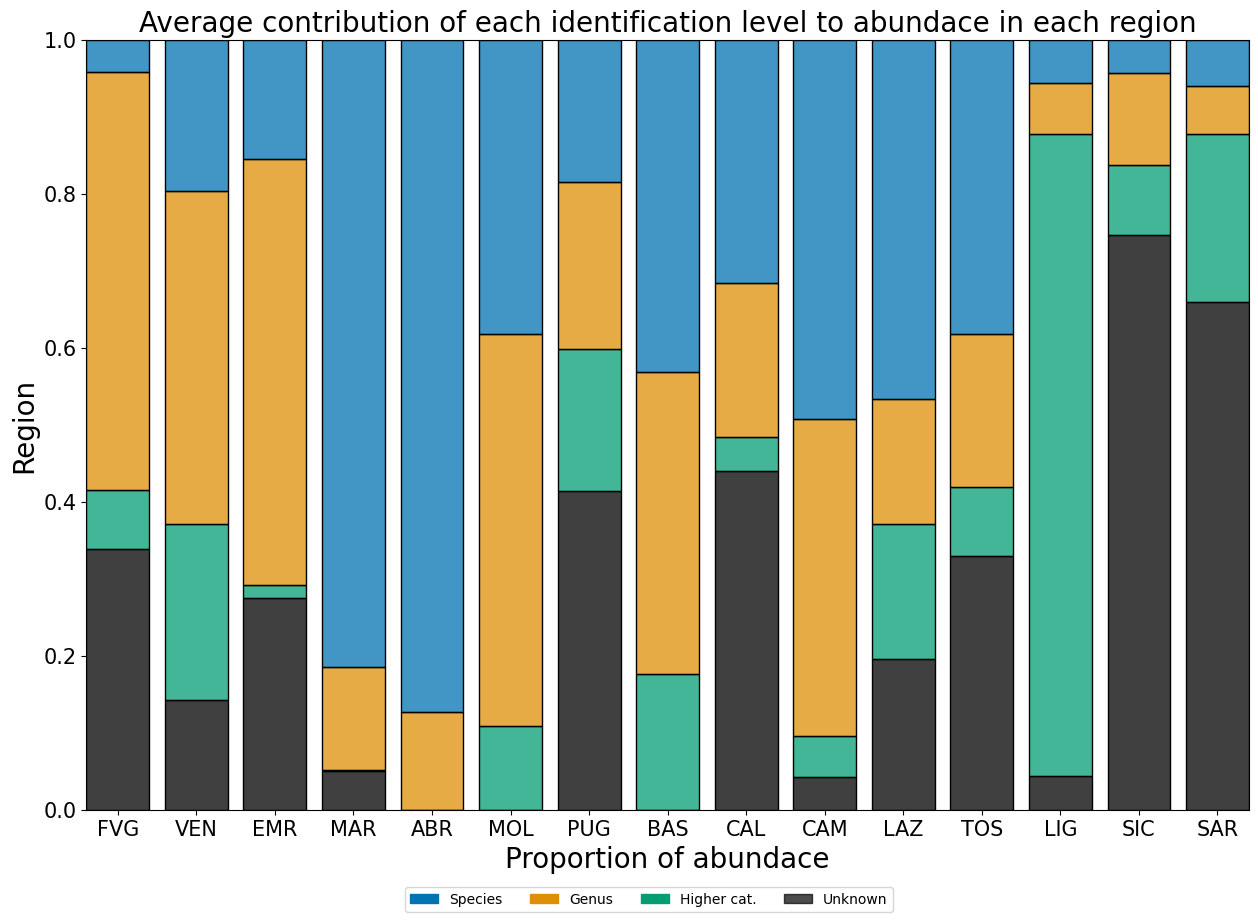

In [69]:
fig, ax = plt.subplots(figsize=(15, 10))
data = phyto_abund_simplified.groupby(["Date", "id", "Det_level"]).agg(
        {
            "Num_cell_l" : "sum", 
            "Region" : "first"
        }).reset_index().groupby(["Region", "Det_level"], observed = True).mean(numeric_only=True).reset_index().rename(columns={"Det_level" : "Identification level"})
data["Identification level"] = pd.Categorical(data["Identification level"], categories = ["Unknown", "Higher cat.", "Genus", "Species"][::-1], ordered = True)
num_colors = len(["Unknown", "Higher cat.", "Genus", "Species"])
colors = sns.color_palette("colorblind", num_colors)
colors[-1] = [0,0,0,0.7]#sns.color_palette("tab10", 4)[-1]
color_dict = {name: color for name, color in zip(["Unknown", "Higher cat.", "Genus", "Species"][::-1], colors)}
sns.histplot(
        data=data.sort_values(by="Identification level"),
        x="Region", hue="Identification level", weights="Num_cell_l",
        multiple="fill", stat="proportion",
        discrete=True, shrink=.8, legend=False, palette=color_dict,
        ax = ax
    )
ax.set_xlabel("Proportion of abundace", size = 20)
ax.set_ylabel("Region", size = 20)
ax.set_xticks(ticks=ax.get_xticks(), labels = ax.get_xticklabels(), size = 15)
ax.set_yticks(ticks=ax.get_yticks(), labels = ax.get_yticklabels(), size = 15)
ax.set_title("Average contribution of each identification level to abundace in each region", size = 20)
handles, labels = ax.get_legend_handles_labels()
handles = [mpatches.Patch(color=color_dict[name], label=name) for i, name in enumerate(["Unknown", "Higher cat.", "Genus", "Species"][::-1])]
fig.legend(handles=handles, bbox_to_anchor=(0, -.03, 1, 0.101), loc='center', ncol=4)
plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Description/average_proportion_cells_per_region_and_identification_level.png", bbox_inches="tight")

In [76]:
phyto_classes = pd.read_csv(_HOME_ + "/ISPRA_20152017_Analysis/Description/phyto_classes.csv")

In [77]:
top_taxa = pd.read_csv(_HOME_ + "/ISPRA_20152017_Analysis/Description/Taxa_freq_95.csv")
top_species = pd.read_csv(_HOME_ + "/ISPRA_20152017_Analysis/Description/Species_freq_top.csv")
top_genera = pd.read_csv(_HOME_ + "/ISPRA_20152017_Analysis/Description/Genera_freq_top.csv")
top_classes = pd.read_csv(_HOME_ + "/ISPRA_20152017_Analysis/Description/Classes_freq_top.csv").dropna()

In [78]:
rich_classes = phyto_abund_simplified.query("Taxon != 'Other phytoplankton' and Det_level == 'Species'")[["Class", "Taxon"]].groupby("Class").nunique().sort_values("Taxon", ascending = False).reset_index()
rich_genera = phyto_abund_simplified.query("Taxon != 'Other phytoplankton' and Det_level == 'Species'")[["Genus", "Taxon"]].groupby("Genus").nunique().sort_values("Taxon", ascending = False).reset_index()

In [122]:
np.round(data.iloc[:n_otu,1].to_numpy() / n_samples, 2)

array([0.62, 0.58, 0.54, 0.53, 0.5 , 0.47, 0.46, 0.45, 0.44, 0.42])

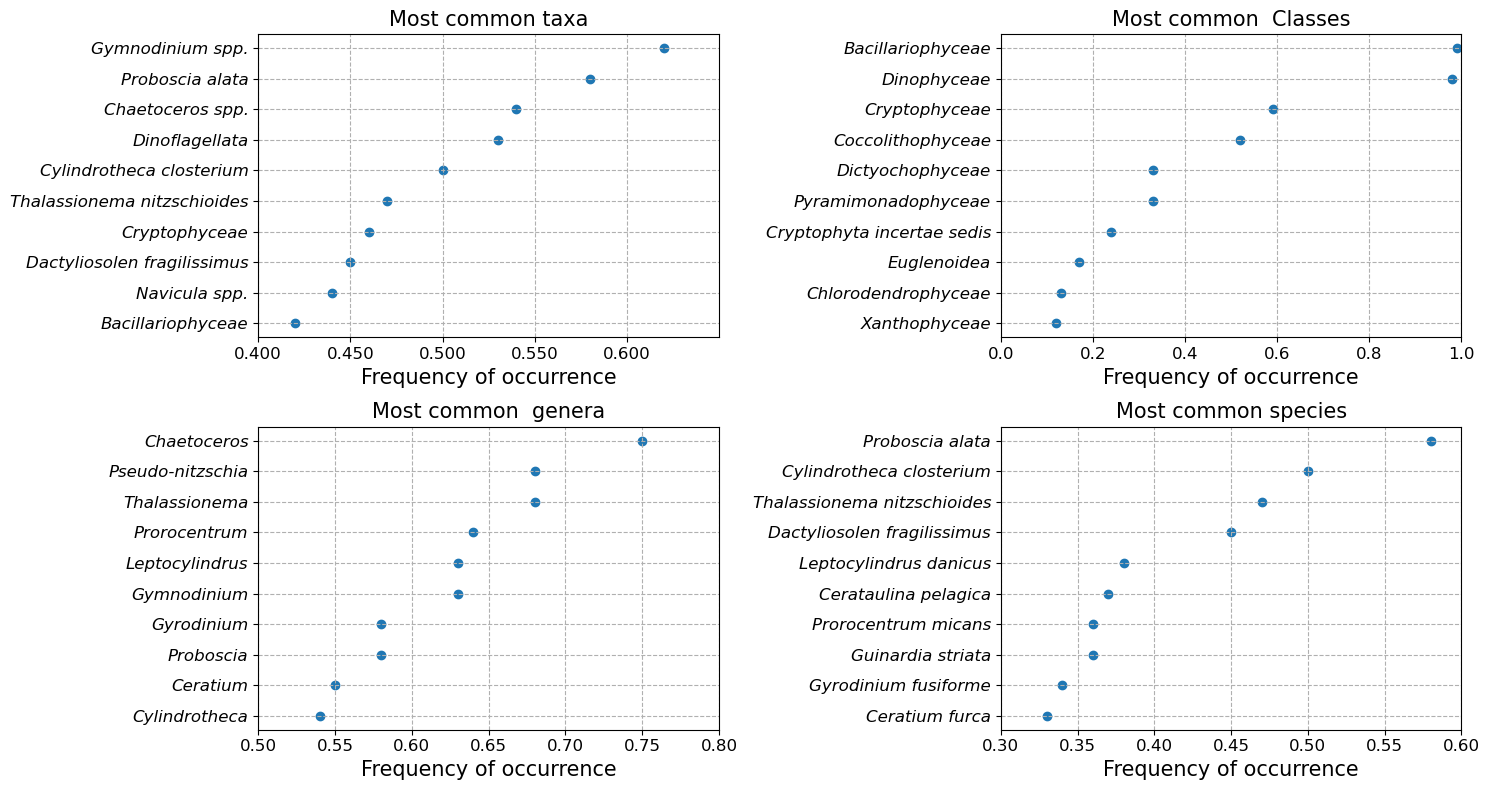

In [132]:
fig, axs = plt.subplots(2, 2, figsize=(15, 8))
axs = axs.flatten()

n_otu = 10
n_samples = 2220
for ax, data, title in zip(axs, 
                           [top_taxa, top_classes, top_genera, top_species], 
                           ["Most common taxa", "Most common  Classes", "Most common  genera", "Most common species"]
                           ):
    ith_otu = np.arange(len(data))[:n_otu][::-1]
    ax.scatter(np.round(data.iloc[:n_otu,1].to_numpy() / n_samples, 2), ith_otu)
    ax.set_title(title, size = 15)
    ax.set_xticks(ticks=ax.get_xticks(), labels = ax.get_xticklabels(), size = 12)
    ax.set_yticks(
        ith_otu, 
        labels = data.iloc[:n_otu,0].to_numpy(), 
        style = "italic", 
        size = 12
    )
    ax.grid(True, which='major', axis="both", linestyle='--')
    ax.set_xlabel("Frequency of occurrence", size = 15)
    
axs[0].set_xticks(ticks=axs[0].get_xticks()[:-1:2], labels = axs[0].get_xticklabels()[:-1:2], size = 12)
axs[1].set_xlim(0,1)
plt.tight_layout()
plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Description/most_common_taxa_classes_genera_species.png", bbox_inches="tight")

In [21]:
def order_species(df, basins, threshold = 0.5): 
    
    characteristic_species = df.index[np.where(df.loc[:, basins].max(axis = 1) >= threshold)]
    df_long = df.loc[characteristic_species, basins].reset_index().melt(id_vars="Taxon", var_name="Basin", value_name="Value")
    df_long["Basin"] = pd.Categorical(df_long["Basin"], categories=basins, ordered=True)
    idx = df_long.groupby("Taxon")["Value"].idxmax()
    ordered_ids = df_long.loc[idx].sort_values(["Basin", "Value"], ascending=[True, False])["Taxon"]
    return ordered_ids

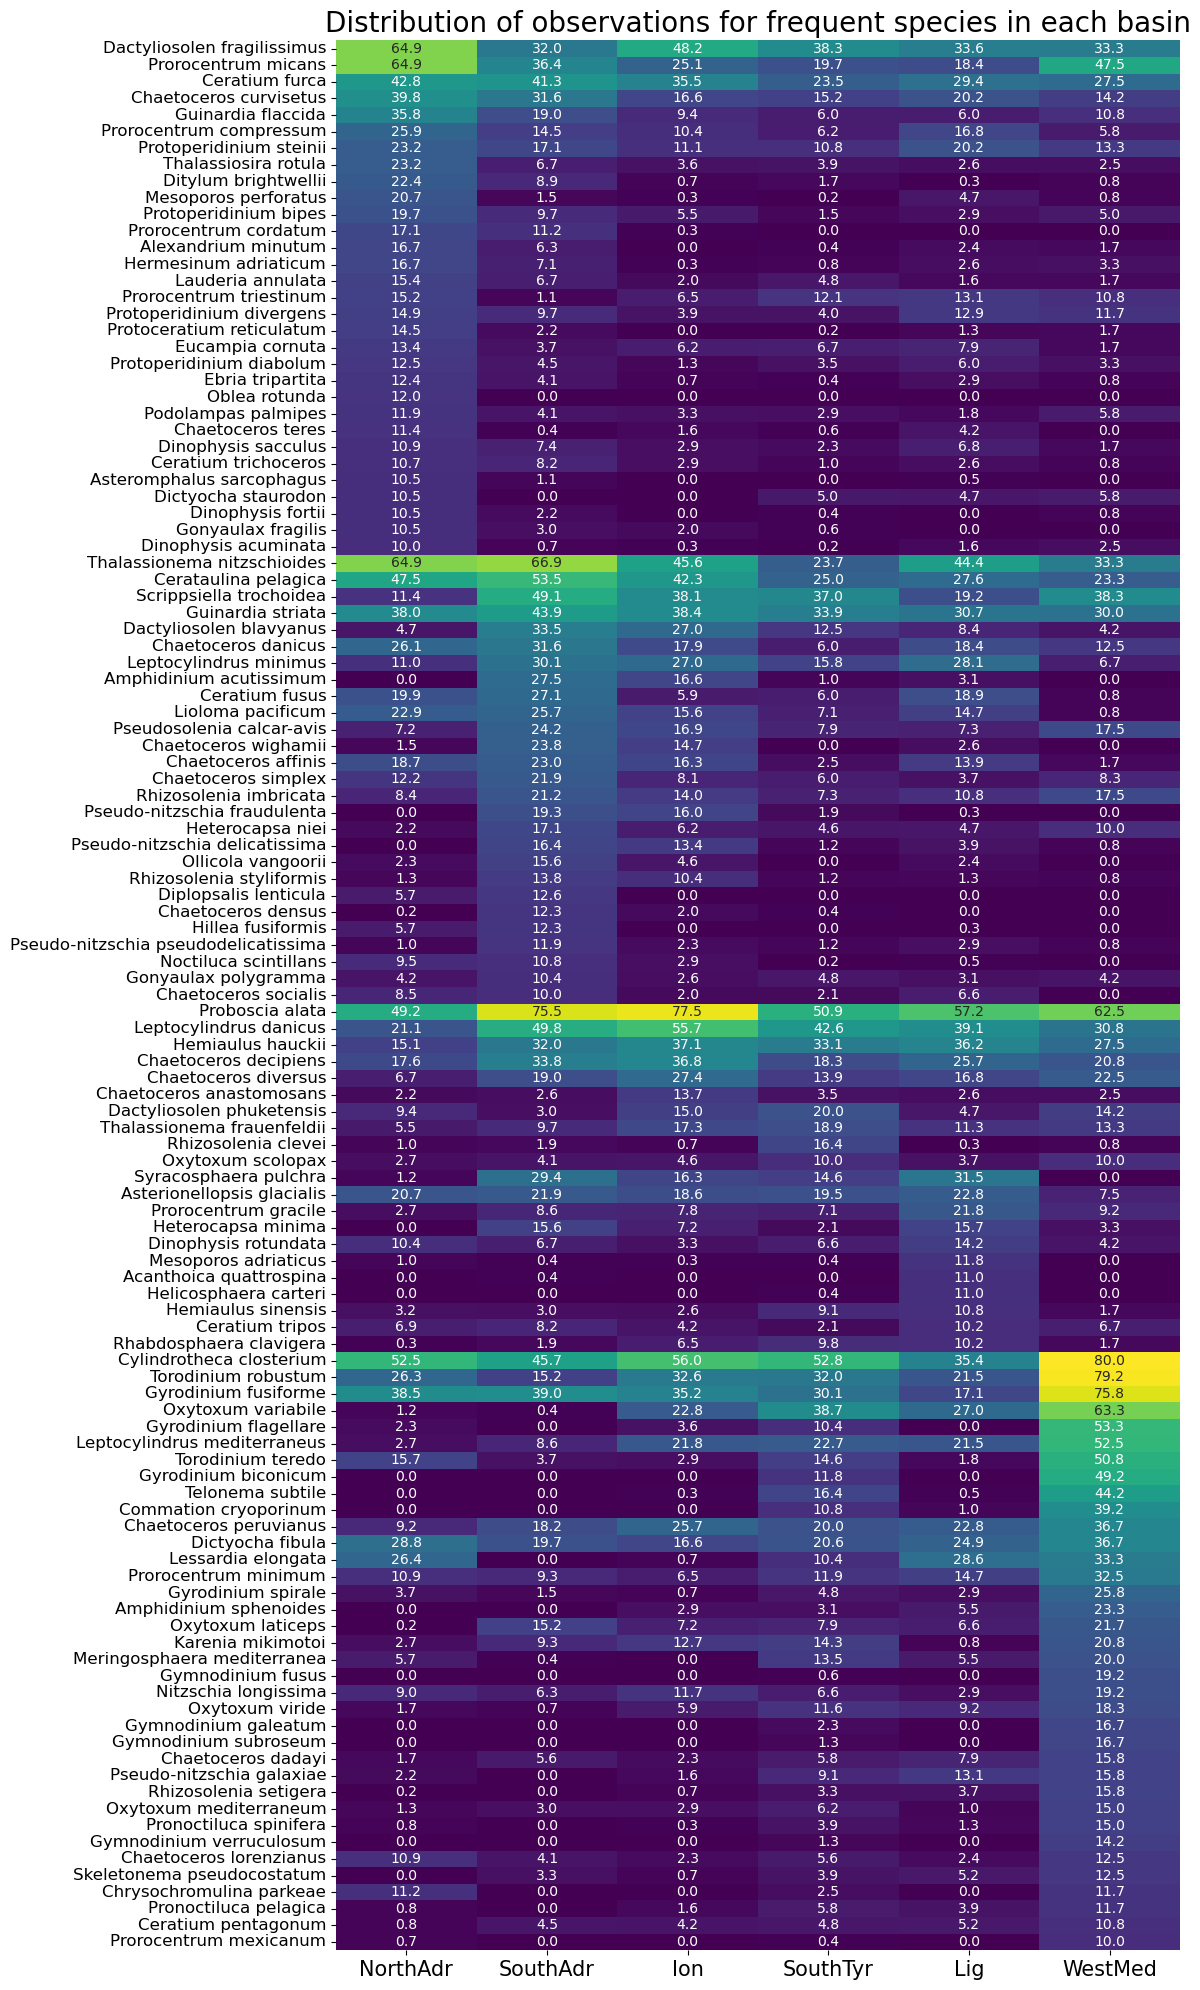

In [28]:

fig, ax = plt.subplots(figsize=(12, 20))

pres_abs = phyto_abund_simplified.query("Det_level == 'Species'").pivot_table(
    index= ["Basin", "Date", "id"], 
    columns="Taxon",
    values="Num_cell_l",
    aggfunc="mean",
    fill_value=0
) > 0
pres_abs.reset_index(inplace=True)
n_region_samples = pres_abs.drop_duplicates(["Date", "id"]).groupby("Basin", observed=True).count()["id"].to_numpy()
rel_freq = pres_abs.groupby("Basin", observed=True).sum(numeric_only=True).apply(lambda x: x / n_region_samples, axis=0).T * 100
most_freq_species = order_species(rel_freq, ["NorthAdr", "SouthAdr", "Ion", "SouthTyr",  "Lig", "WestMed"], threshold=10)
sns.heatmap(
data = rel_freq.loc[most_freq_species, ["NorthAdr", "SouthAdr", "Ion", "SouthTyr",  "Lig", "WestMed"]], 
cmap = "viridis",
annot=True,
fmt=".1f",
ax = ax, 
cbar=False
)
ax.set_yticks(np.arange(most_freq_species.size) + 0.5);
ax.set_yticklabels(most_freq_species, rotation=0, size = 12);
ax.set_xticks(ax.get_xticks());
ax.set_xticklabels(ax.get_xticklabels(), fontsize = 15);
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_title("Distribution of observations for frequent species in each basin", fontsize = 20)
plt.tight_layout()
#plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Description/Species_abund_95_heatmap.png", dpi = 300, bbox_inches = "tight")

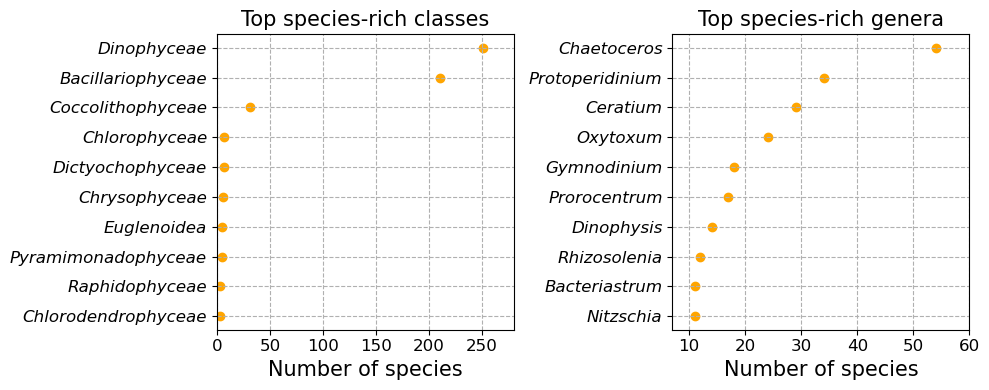

In [143]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs = axs.flatten()

for ax, data, title in zip(axs, [rich_classes, rich_genera], ["Top species-rich classes", "Top species-rich genera"]):
    ith_otu = np.arange(len(data))[:n_otu][::-1]
    ax.scatter(data.iloc[:n_otu,1].to_numpy(), ith_otu, color = "orange")
    ax.set_yticks(
        ith_otu, 
        labels = data.iloc[:n_otu,0].to_numpy(), 
        style = "italic", 
        size = 12
    )
    ax.set_title(title, size = 15)
    ax.set_xlabel("Number of species", size = 15)
    ax.set_xticks(ticks=ax.get_xticks(), labels = ax.get_xticklabels(), size = 12)
    ax.grid(True, which='major', axis="both", linestyle='--')
axs[0].set_xlim(0,280)
axs[1].set_xlim(7,60)
plt.tight_layout()
plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Description/top_species_rich_classes_genera.png", bbox_inches="tight")

In [164]:
taxa_frequnecy = phyto_abund_simplified.groupby("Taxon").count()[["Num_cell_l"]].sort_values("Num_cell_l", ascending = False) / 2220
print(f"Number of rare taxa: {len(taxa_frequnecy.query("Num_cell_l < 0.01"))}")
print(f"Number of intermediate taxa: {len(taxa_frequnecy.query("Num_cell_l >= 0.01 and Num_cell_l < 0.1"))}")
print(f"Number of common taxa: {len(taxa_frequnecy.query("Num_cell_l >= 0.1"))}")

Number of rare taxa: 462
Number of intermediate taxa: 228
Number of common taxa: 77


In [167]:
genus_frequnecy = phyto_abund_simplified.groupby("Class").count()[["Num_cell_l"]].sort_values("Num_cell_l", ascending = False) / 2220
print(f"Number of rare genus: {len(genus_frequnecy.query("Num_cell_l < 0.01"))}")
print(f"Number of intermediate genus: {len(genus_frequnecy.query("Num_cell_l >= 0.01 and Num_cell_l < 0.1"))}")
print(f"Number of common genus: {len(genus_frequnecy.query("Num_cell_l >= 0.1"))}")

Number of rare genus: 0
Number of intermediate genus: 0
Number of common genus: 0


In [174]:
genus_frequnecy = phyto_abund_simplified.query("Det_level == 'Genus'").groupby("Genus").count()[["Num_cell_l"]].sort_values("Num_cell_l", ascending = False) / 2220
print(f"Number of rare genus: {len(genus_frequnecy.query("Num_cell_l < 0.01"))}")
print(f"Number of intermediate genus: {len(genus_frequnecy.query("Num_cell_l >= 0.01 and Num_cell_l < 0.1"))}")
print(f"Number of common genus: {len(genus_frequnecy.query("Num_cell_l >= 0.1"))}")

Number of rare genus: 109
Number of intermediate genus: 56
Number of common genus: 28


In [165]:
species_frequnecy = phyto_abund_simplified.query("Det_level == 'Species'").groupby("Taxon").count()[["Num_cell_l"]].sort_values("Num_cell_l", ascending = False) / 2220
print(f"Number of rare species: {len(species_frequnecy.query("Num_cell_l < 0.01"))}")
print(f"Number of intermediate species: {len(species_frequnecy.query("Num_cell_l >= 0.01 and Num_cell_l < 0.1"))}")
print(f"Number of common species: {len(species_frequnecy.query("Num_cell_l >= 0.1"))}")

Number of rare species: 343
Number of intermediate species: 162
Number of common species: 39


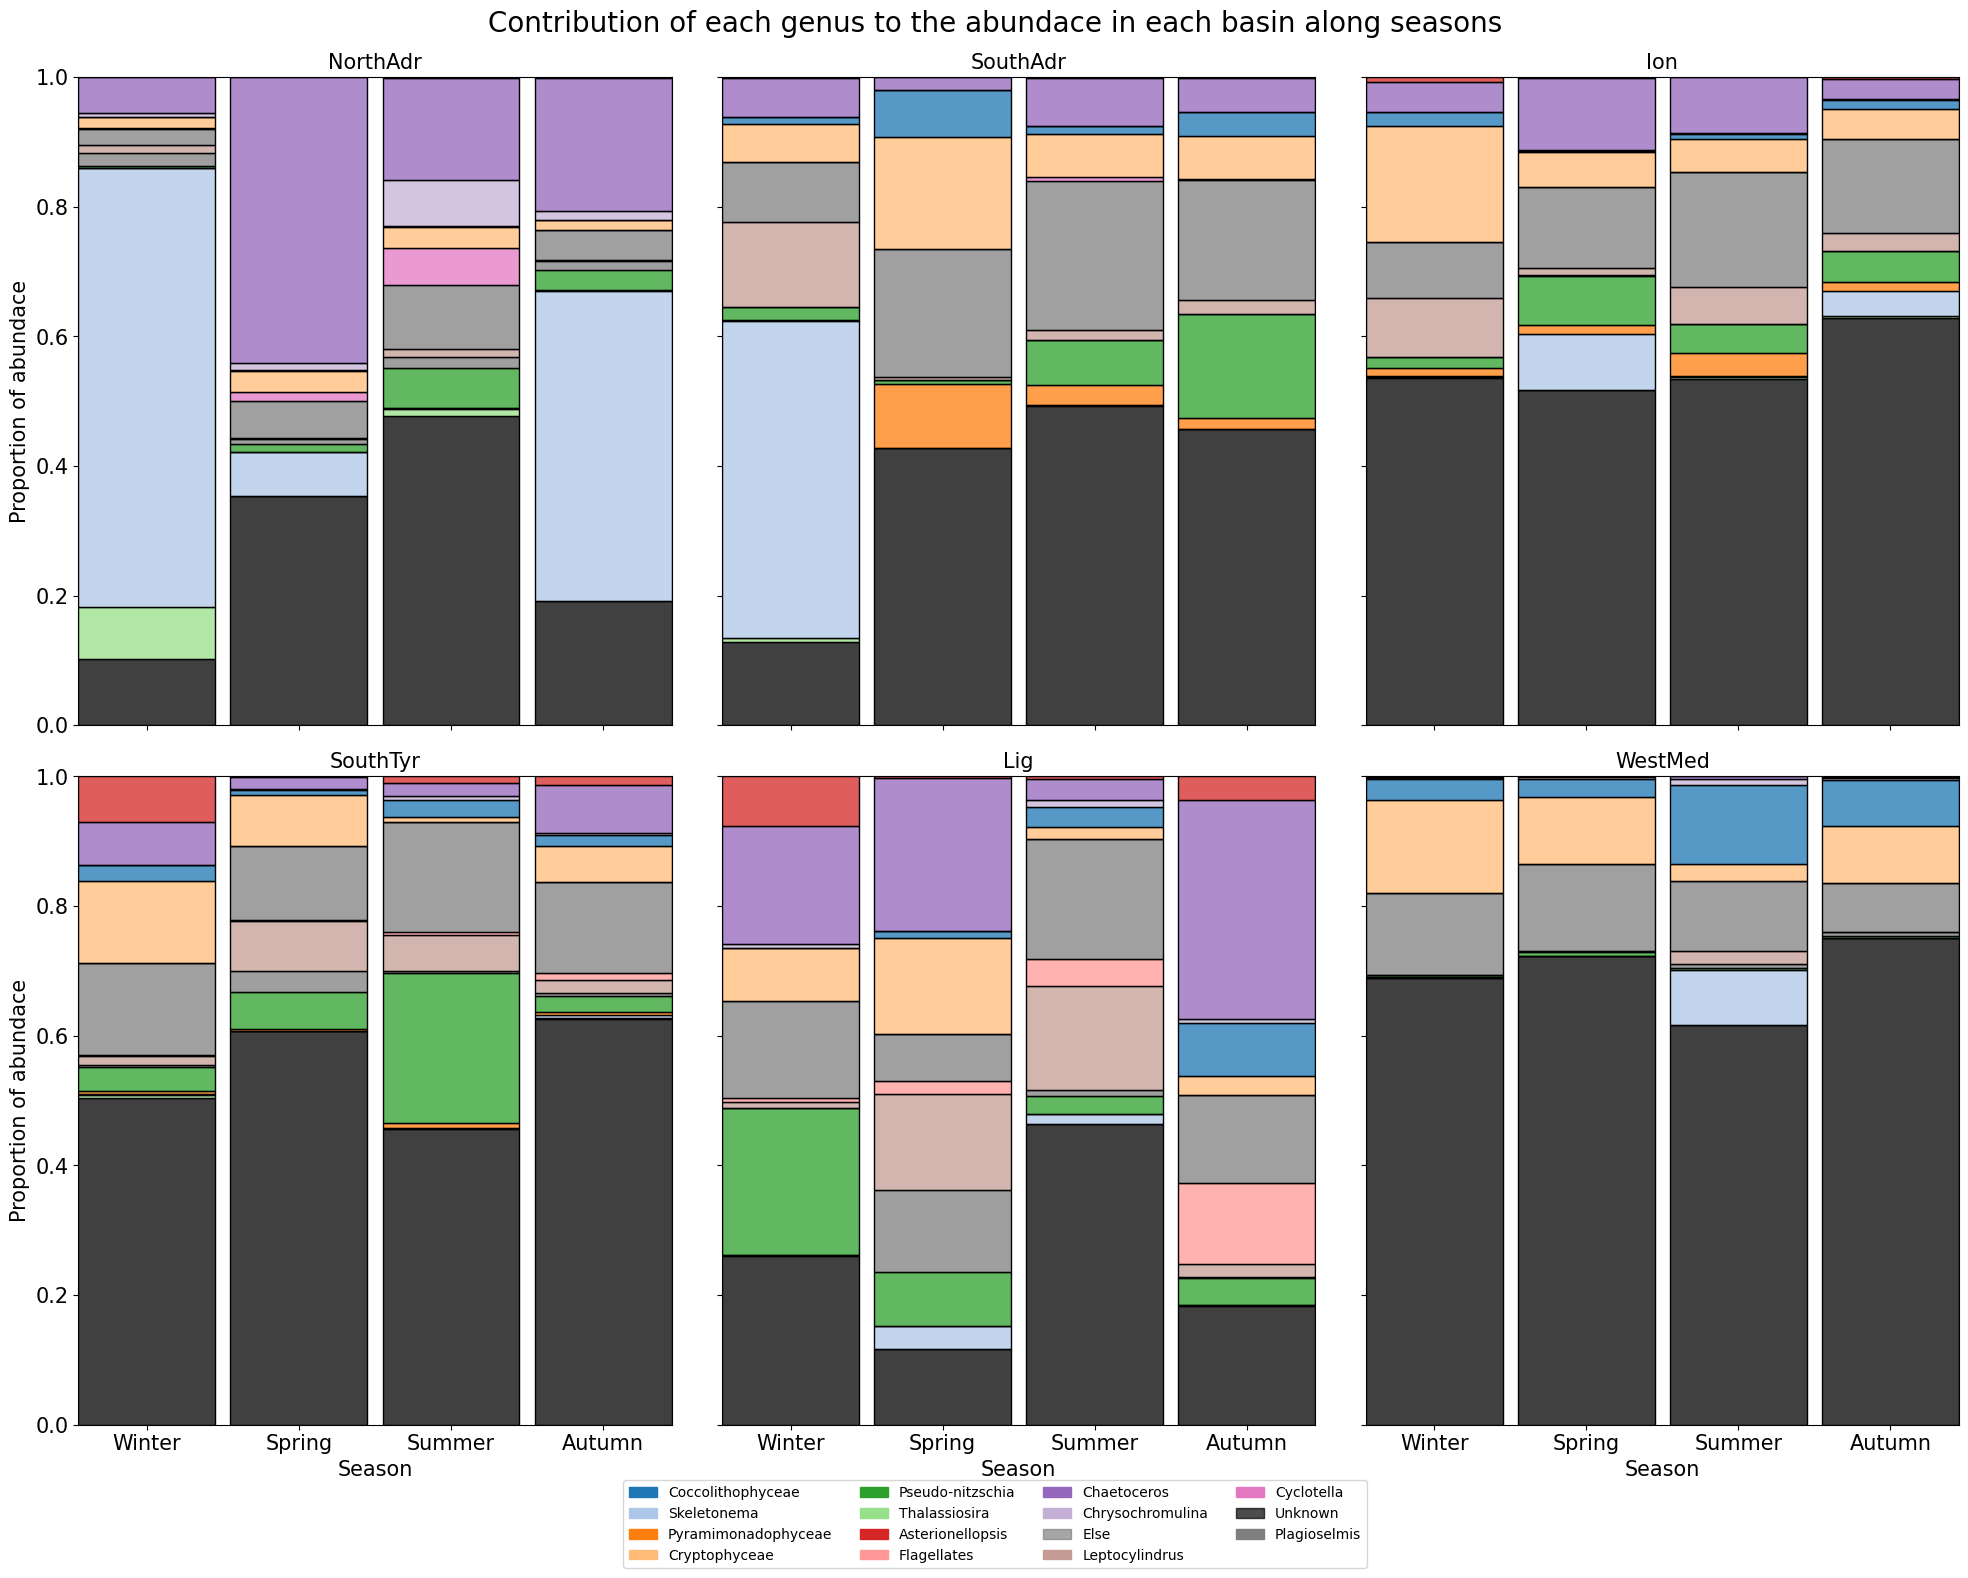

In [120]:
det_level = "Genus"
df = phyto_abund_simplified.loc[:, ["Taxon", det_level, "Class", "Num_cell_l", "Basin", "Season"]]
df.loc[df["Genus"].isna(), "Genus"] = df.loc[df[det_level].isna(), "Taxon"]
df.loc[df["Genus"] == "Other phytoplankton", "Genus"] = "Unknown"
df["Basin"] = pd.Categorical(df["Basin"], categories = ["NorthAdr", "SouthAdr", "Ion", "SouthTyr", "Lig", "WestMed"], ordered = True)
taxa_abund_season_basin = df.groupby(["Basin", "Season", det_level], observed=True).sum(numeric_only=True)[["Num_cell_l"]]

fig, axs = plt.subplots(2, 3, figsize=(20, 15), sharey=True, sharex=True)
axs = axs.ravel()
taxa_above_threshold = set()
for basin_name, df_basin in taxa_abund_season_basin.groupby("Basin", observed=True): 
    taxa_above_threshold = taxa_above_threshold.union(
    df_basin.div(df_basin.groupby(level = "Season", observed = True).sum(numeric_only=True)).query("Num_cell_l > 0.05").index.get_level_values(det_level).unique()
    )

taxa_above_threshold = taxa_above_threshold.union(["Else"])
num_colors = len(taxa_above_threshold)
colors = sns.color_palette("tab20", num_colors)
color_dict = {name: color for name, color in zip(taxa_above_threshold, colors)}
#color_dict["Bacillariophyceae"] = [123 / 255, 62 / 255, 228 / 255, 0.7]
color_dict["Else"] = [0.5, 0.5, 0.5, 0.7]
color_dict["Unknown"] = [0,0,0,0.7]#sns.color_palette("tab10", 4)[-1]

for ax, (basin_name, df_basin) in zip(axs, taxa_abund_season_basin.groupby("Basin", observed=True)): 
    df = df_basin.reset_index()
    df.loc[~df[det_level].isin(taxa_above_threshold), det_level] = "Else"

    sns.histplot(
        data=df.groupby(["Season", det_level], observed=True).sum(numeric_only=True).sort_values(by = det_level),
        x="Season", hue=det_level, weights="Num_cell_l",
        multiple="fill", stat="proportion",
        palette = color_dict,
        discrete=True, shrink=.9, legend=False,
        ax = ax
    )
    ax.set_title(basin_name, size = 15)
    
    
for ax in axs[[0,3]]: 
    ax.set_ylabel("Proportion of abundace", size = 15)
    ax.set_yticks(ticks=ax.get_yticks(), labels = ax.get_yticklabels(), size = 15)

for ax in axs[[3,4,5]]: 
    ax.set_xticks(ticks=ax.get_xticks(), labels = ax.get_xticklabels(), size = 15)
    ax.set_xlabel("Season", size = 15)

handles = [mpatches.Patch(color=color_dict[name], label=name) for name in taxa_above_threshold]
fig.legend(handles=handles, bbox_to_anchor=(0, -.07, 1, 0.101), loc='center', ncol=4)
plt.suptitle("Contribution of each genus to the abundace", size=20, y=0.99)
plt.subplots_adjust(hspace=0.2, wspace=3)
plt.tight_layout()


In [116]:
det_level = "Genus"
df = phyto_abund_simplified.loc[:, ["Taxon", det_level, "Class", "Num_cell_l", "Basin", "Season"]]
df.loc[df["Genus"].isna(), "Genus"] = df.loc[df[det_level].isna(), "Taxon"]
df.loc[df["Genus"] == "Other phytoplankton", "Genus"] = "Unknown"
df["Basin"] = pd.Categorical(df["Basin"], categories = ["NorthAdr", "SouthAdr", "Ion", "SouthTyr", "Lig", "WestMed"], ordered = True)
taxa_abund_season_basin = df.groupby(["Basin", "Season", det_level], observed=True).mean(numeric_only=True)[["Num_cell_l"]]

In [120]:
for basin_name, df_basin in taxa_abund_season_basin.groupby("Basin", observed=True): 
    taxa_above_threshold = taxa_above_threshold.union(
    df_basin.div(df_basin.groupby(level = "Season", observed = True).sum(numeric_only=True)).query("Num_cell_l > 0.08").index.get_level_values(det_level).unique()
    )

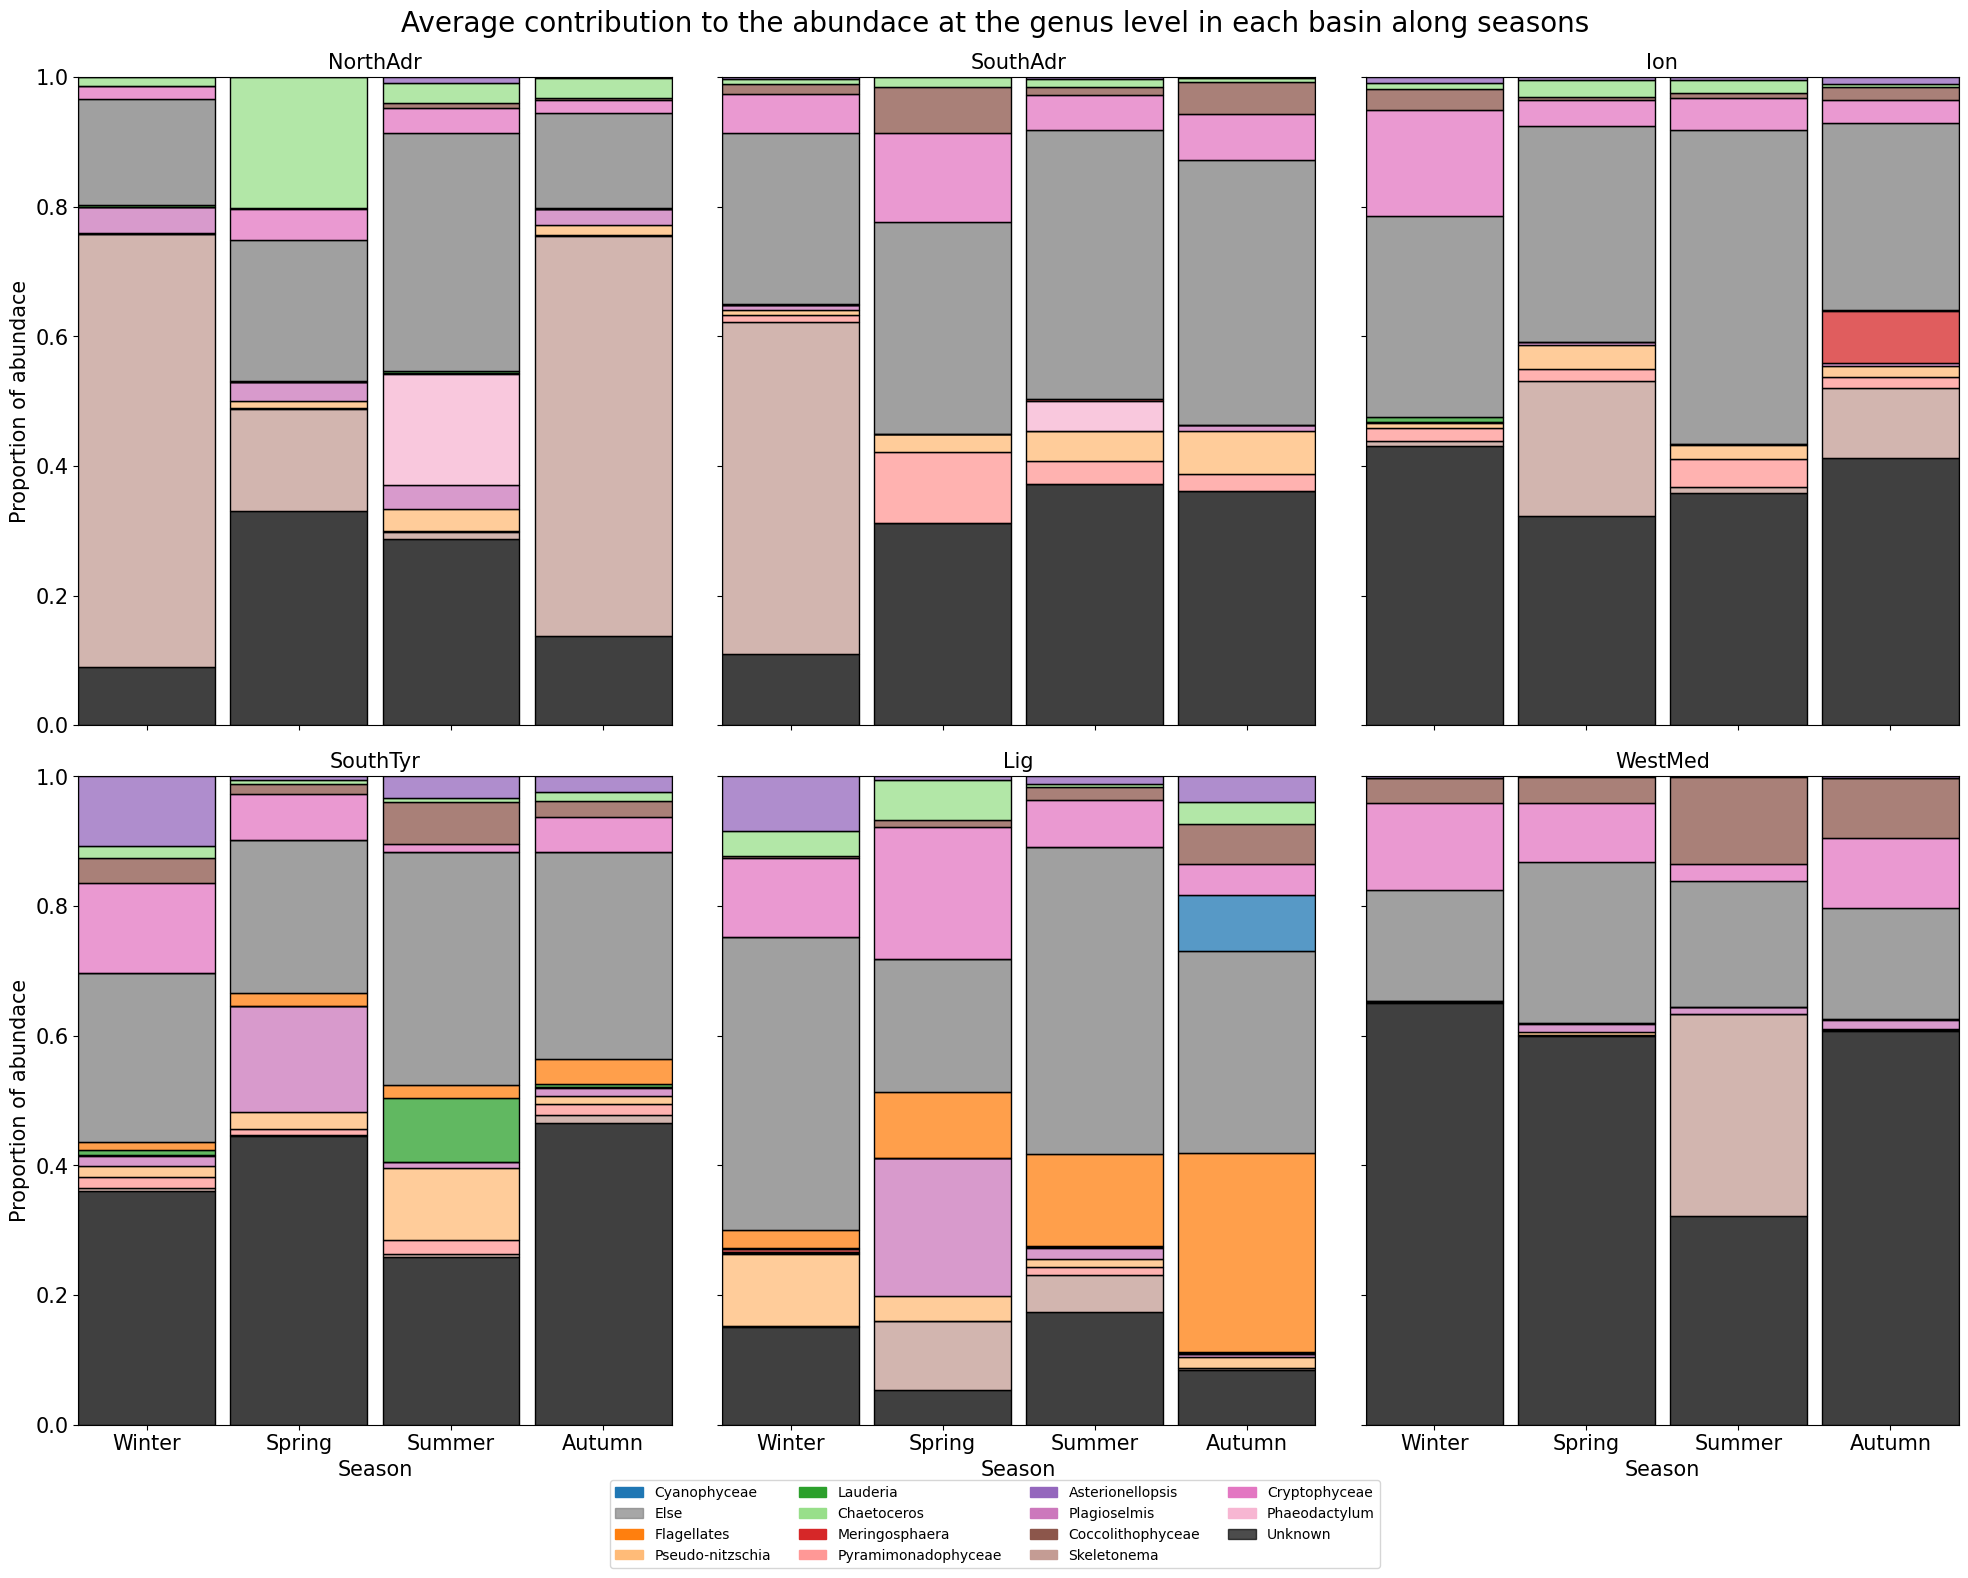

In [118]:
det_level = "Genus"
df = phyto_abund_simplified.loc[:, ["Taxon", det_level, "Class", "Num_cell_l", "Basin", "Season"]]
df.loc[df["Genus"].isna(), "Genus"] = df.loc[df[det_level].isna(), "Taxon"]
df.loc[df["Genus"] == "Other phytoplankton", "Genus"] = "Unknown"
df["Basin"] = pd.Categorical(df["Basin"], categories = ["NorthAdr", "SouthAdr", "Ion", "SouthTyr", "Lig", "WestMed"], ordered = True)
taxa_abund_season_basin = df.groupby(["Basin", "Season", det_level], observed=True).mean(numeric_only=True)[["Num_cell_l"]]

fig, axs = plt.subplots(2, 3, figsize=(20, 15), sharey=True, sharex=True)
axs = axs.ravel()
taxa_above_threshold = set()
for basin_name, df_basin in taxa_abund_season_basin.groupby("Basin", observed=True): 
    taxa_above_threshold = taxa_above_threshold.union(
    df_basin.div(df_basin.groupby(level = "Season", observed = True).sum(numeric_only=True)).query("Num_cell_l > 0.08").index.get_level_values(det_level).unique()
    )

taxa_above_threshold = taxa_above_threshold.union(["Else"])
num_colors = len(taxa_above_threshold)
colors = sns.color_palette("tab20", num_colors)
color_dict = {name: color for name, color in zip(taxa_above_threshold, colors)}
#color_dict["Bacillariophyceae"] = [123 / 255, 62 / 255, 228 / 255, 0.7]
color_dict["Else"] = [0.5, 0.5, 0.5, 0.7]
color_dict["Plagioselmis"] = sns.color_palette("colorblind", 5)[-1]
color_dict["Unknown"] = [0,0,0,0.7]#sns.color_palette("tab10", 4)[-1]

for ax, (basin_name, df_basin) in zip(axs, taxa_abund_season_basin.groupby("Basin", observed=True)): 
    df_basin = df_basin.reset_index()
    df_basin.loc[~df_basin[det_level].isin(taxa_above_threshold), det_level] = "Else"

    sns.histplot(
        data=df_basin.groupby(["Season", det_level], observed=True).sum(numeric_only=True).sort_values(by = det_level),
        x="Season", hue=det_level, weights="Num_cell_l",
        multiple="fill", stat="proportion",
        palette = color_dict,
        discrete=True, shrink=.9, legend=False,
        ax = ax
    )
    ax.set_title(basin_name, size = 15)
    
    
for ax in axs[[0,3]]: 
    ax.set_ylabel("Proportion of abundace", size = 15)
    ax.set_yticks(ticks=ax.get_yticks(), labels = ax.get_yticklabels(), size = 15)

for ax in axs[[3,4,5]]: 
    ax.set_xticks(ticks=ax.get_xticks(), labels = ax.get_xticklabels(), size = 15)
    ax.set_xlabel("Season", size = 15)

handles = [mpatches.Patch(color=color_dict[name], label=name) for name in taxa_above_threshold]
fig.legend(handles=handles, bbox_to_anchor=(0, -.07, 1, 0.101), loc='center', ncol=4)
plt.suptitle("Average contribution to the abundace at the genus level in each basin along seasons", size=20, y=0.99)
plt.subplots_adjust(hspace=0.2, wspace=3)
plt.tight_layout()
fig.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Description/average_proportion_cells_genus_level_region_along_basin.png", bbox_inches="tight")

In [61]:
det_level = "Genus"
df = phyto_abund_simplified.loc[:, ["Taxon", det_level, "Class", "Num_cell_l", "Basin", "Season"]]
df.loc[df["Genus"].isna(), "Genus"] = df.loc[df[det_level].isna(), "Taxon"]
df.loc[df["Genus"] == "Other phytoplankton", "Genus"] = "Unknown"
df["Basin"] = pd.Categorical(df["Basin"], categories = ["NorthAdr", "SouthAdr", "Ion", "SouthTyr", "Lig", "WestMed"], ordered = True)
taxa_abund_season_basin = df.groupby(["Basin", "Season", det_level], observed=True).mean(numeric_only=True)[["Num_cell_l"]]

# SAR analysis

In [29]:
import skbio.stats.distance as ssd
from scipy.spatial.distance import pdist, squareform

## west vs east

In [47]:
sard_abund = phyto_abund_simplified.query("Region == 'SAR' and Det_level == 'Genus'").pivot_table(
    index = ["Basin", "Date", "id"], columns = "Genus", values = "Num_cell_l", fill_value = 0, aggfunc="sum"
    )

In [48]:
bc_dist = ssd.DistanceMatrix( squareform(pdist(sard_abund.apply(lambda x: np.sqrt(x / sum(x)), axis = 1).values, metric = "euclidean")), list(range(sard_abund.shape[0])))
anosim_res = ssd.anosim(bc_dist, sard_abund.index.get_level_values(0).to_list(), permutations=999)
print("euclidean", anosim_res["test statistic"], anosim_res["p-value"])

bc_dist = ssd.DistanceMatrix( squareform(pdist(sard_abund.values, metric = "braycurtis")), list(range(sard_abund.shape[0])))
anosim_res = ssd.anosim(bc_dist, sard_abund.index.get_level_values(0).to_list(), permutations=999)
print("braycurtis", anosim_res["test statistic"], anosim_res["p-value"])

bc_dist = ssd.DistanceMatrix( squareform(pdist(sard_abund.apply(lambda x: np.sqrt(x / sum(x)), axis = 1).values, metric = "braycurtis")), list(range(sard_abund.shape[0])))
anosim_res = ssd.anosim(bc_dist, sard_abund.index.get_level_values(0).to_list(), permutations=999)
print("braycurtis-hell", anosim_res["test statistic"], anosim_res["p-value"])

euclidean 0.05456739253530871 0.001
braycurtis 0.037137924647687476 0.003
braycurtis-hell 0.04906455836936076 0.001


In [49]:
sard_abund = phyto_abund_simplified.query("Region == 'SAR' and Det_level == 'Species'").pivot_table(
    index = ["Basin", "Date", "id"], columns = "Genus", values = "Num_cell_l", fill_value = 0, aggfunc="sum"
    )

In [50]:
bc_dist = ssd.DistanceMatrix( squareform(pdist(sard_abund.apply(lambda x: np.sqrt(x / sum(x)), axis = 1).values, metric = "euclidean")), list(range(sard_abund.shape[0])))
anosim_res = ssd.anosim(bc_dist, sard_abund.index.get_level_values(0).to_list(), permutations=999)
print("euclidean", anosim_res["test statistic"], anosim_res["p-value"])

bc_dist = ssd.DistanceMatrix( squareform(pdist(sard_abund.values, metric = "braycurtis")), list(range(sard_abund.shape[0])))
anosim_res = ssd.anosim(bc_dist, sard_abund.index.get_level_values(0).to_list(), permutations=999)
print("braycurtis", anosim_res["test statistic"], anosim_res["p-value"])

bc_dist = ssd.DistanceMatrix( squareform(pdist(sard_abund.apply(lambda x: np.sqrt(x / sum(x)), axis = 1).values, metric = "braycurtis")), list(range(sard_abund.shape[0])))
anosim_res = ssd.anosim(bc_dist, sard_abund.index.get_level_values(0).to_list(), permutations=999)
print("braycurtis-hell", anosim_res["test statistic"], anosim_res["p-value"])

euclidean 0.0466644364265814 0.001
braycurtis 0.04048281988551523 0.001
braycurtis-hell 0.048329764456598485 0.001


## SouthTyr

In [52]:
tyr_abund = phyto_abund_simplified.query("Basin == 'SouthTyr' and Det_level == 'Genus'").pivot_table(
    index = ["Region", "Date", "id"], columns = "Genus", values = "Num_cell_l", fill_value = 0, aggfunc="sum", observed=True
    )
    

In [56]:
is_sard = list(map(lambda x: x == "SAR", tyr_abund.index.get_level_values(0).to_list()))

In [57]:
bc_dist = ssd.DistanceMatrix( squareform(pdist(tyr_abund.apply(lambda x: np.sqrt(x / sum(x)), axis = 1).values, metric = "euclidean")), list(range(tyr_abund.shape[0])))
anosim_res = ssd.anosim(bc_dist, is_sard, permutations=999)
print("euclidean", anosim_res["test statistic"], anosim_res["p-value"])

bc_dist = ssd.DistanceMatrix( squareform(pdist(tyr_abund.values, metric = "braycurtis")), list(range(tyr_abund.shape[0])))
anosim_res = ssd.anosim(bc_dist, is_sard, permutations=999)
print("braycurtis", anosim_res["test statistic"], anosim_res["p-value"])

bc_dist = ssd.DistanceMatrix( squareform(pdist(tyr_abund.apply(lambda x: np.sqrt(x / sum(x)), axis = 1).values, metric = "braycurtis")), list(range(tyr_abund.shape[0])))
anosim_res = ssd.anosim(bc_dist, is_sard, permutations=999)
print("braycurtis-hell", anosim_res["test statistic"], anosim_res["p-value"])

euclidean 0.3584759369686101 0.001
braycurtis 0.278288772120775 0.001
braycurtis-hell 0.3860683205613383 0.001


In [58]:
tyr_abund = phyto_abund_simplified.query("Basin == 'SouthTyr' and Det_level == 'Species'").pivot_table(
    index = ["Region", "Date", "id"], columns = "Genus", values = "Num_cell_l", fill_value = 0, aggfunc="sum", observed=True
    )

In [59]:
is_sard = list(map(lambda x: x == "SAR", tyr_abund.index.get_level_values(0).to_list()))

In [60]:
bc_dist = ssd.DistanceMatrix( squareform(pdist(tyr_abund.apply(lambda x: np.sqrt(x / sum(x)), axis = 1).values, metric = "euclidean")), list(range(tyr_abund.shape[0])))
anosim_res = ssd.anosim(bc_dist, is_sard, permutations=999)
print("euclidean", anosim_res["test statistic"], anosim_res["p-value"])

bc_dist = ssd.DistanceMatrix( squareform(pdist(tyr_abund.values, metric = "braycurtis")), list(range(tyr_abund.shape[0])))
anosim_res = ssd.anosim(bc_dist, is_sard, permutations=999)
print("braycurtis", anosim_res["test statistic"], anosim_res["p-value"])

bc_dist = ssd.DistanceMatrix( squareform(pdist(tyr_abund.apply(lambda x: np.sqrt(x / sum(x)), axis = 1).values, metric = "braycurtis")), list(range(tyr_abund.shape[0])))
anosim_res = ssd.anosim(bc_dist, is_sard, permutations=999)
print("braycurtis-hell", anosim_res["test statistic"], anosim_res["p-value"])

euclidean 0.1599660598987604 0.001
braycurtis 0.08127865399191751 0.001
braycurtis-hell 0.15454679412637695 0.001
